In [1]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
import matplotlib.pyplot as plt
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
import math

In [2]:
base_url = "https://nextspaceflight.com/launches/past/"
last_page = 4


In [3]:


options = Options()
options.add_argument("--headless=new")
browser = webdriver.Chrome(options=options)

launch_data = []
for page in range(1, last_page + 1):
    browser.get(f"{base_url}?page={page}")
    cards = browser.find_elements(By.CLASS_NAME, "mdl-card")
    for card in cards:
        company = card.find_element(By.CLASS_NAME, "mdl-card__title-text").text
        rocket_and_payload = card.find_element(By.CLASS_NAME, "header-style").text
        date_and_location = card.find_element(By.CLASS_NAME, "mdl-card__supporting-text").text
        details_url = card.find_element(By.CLASS_NAME, "mdc-button").get_attribute("href")
        border_color = card.value_of_css_property("border-top-color")

        if "rgba(69, 207, 93, 1)" == border_color:
            successful = "1" #Exito
        else:
            successful = "0" #Fracaso

        launch_dict = {
            'company': company,
            'rocket_and_payload': rocket_and_payload,
            'date_and_location': date_and_location,
            'details_url': details_url,
            'successful': successful
        }
        launch_data.append(launch_dict)
browser.quit()

df = pd.DataFrame(launch_data, columns=['company', 'rocket_and_payload', 'date_and_location', 'details_url', 'successful'])

In [4]:
browser = webdriver.Chrome(options=options)
wait = WebDriverWait(browser, 10)


prices = []
leo_weights = []  
gto_weights = []  
rocket_heights = []
fairing_diameters = []
fairing_heights = []

for index in range(len(df.details_url)):
    print(f"Processing launch {index + 1}/{len(df.details_url)}")#pensar en quitar
    browser.get(df.details_url[index])

    details_els = wait.until(EC.presence_of_all_elements_located((By.CLASS_NAME, "mdl-card__supporting-text")))
    details_texts = [el.text for el in details_els]

    price = 0.0
    leo_weight = 0
    gto_weight = 0
    rocket_h = 0.0
    fairing_d = 0.0
    fairing_h = 0.0

    if len(details_texts) > 1:
        parts = details_texts[1].split("\n")
        for part in parts:
            if "Price: " in part:
                price = part.replace("Price: $", "").replace(" million", "").strip()
                price = float(price)
            elif "Payload to LEO:" in part:
                leo_weight = part.replace("Payload to LEO:", "").replace("kg", "").strip()
                leo_weight = int(leo_weight.replace(',', ''))
            elif "Payload to GTO:" in part:
                gto_weight = part.replace("Payload to GTO:", "").replace("kg", "").strip()
                gto_weight = int(gto_weight.replace(',', ''))
            elif "Rocket Height:" in part:  
                rocket_h = part.replace("Rocket Height:", "").replace("m", "").strip()
                rocket_h = float(rocket_h)
            elif "Fairing Diameter:" in part:
                fairing_d = part.replace("Fairing Diameter:", "").replace("m", "").strip()
                fairing_d = float(fairing_d)
            elif "Fairing Height:" in part:
                fairing_h = part.replace("Fairing Height:", "").replace("m", "").strip()
                fairing_h = float(fairing_h)

   
    prices.append(price)
    leo_weights.append(leo_weight)
    gto_weights.append(gto_weight)
    rocket_heights.append(rocket_h)
    fairing_diameters.append(fairing_d)
    fairing_heights.append(fairing_h)

browser.quit()


df["price_million"] = prices
df["leo_weight_kg"] = leo_weights
df["gto_weight_kg"] = gto_weights
df["total_payload_kg"] = df["leo_weight_kg"] + df["gto_weight_kg"]
df["rocket_height_m"] = rocket_heights
df["fairing_diameter_m"] = fairing_diameters
df["fairing_height_m"] = fairing_heights

df

Processing launch 1/120
Processing launch 2/120
Processing launch 3/120
Processing launch 4/120
Processing launch 5/120
Processing launch 6/120
Processing launch 7/120
Processing launch 8/120
Processing launch 9/120
Processing launch 10/120
Processing launch 11/120
Processing launch 12/120
Processing launch 13/120
Processing launch 14/120
Processing launch 15/120
Processing launch 16/120
Processing launch 17/120
Processing launch 18/120
Processing launch 19/120
Processing launch 20/120
Processing launch 21/120
Processing launch 22/120
Processing launch 23/120
Processing launch 24/120
Processing launch 25/120
Processing launch 26/120
Processing launch 27/120
Processing launch 28/120
Processing launch 29/120
Processing launch 30/120
Processing launch 31/120
Processing launch 32/120
Processing launch 33/120
Processing launch 34/120
Processing launch 35/120
Processing launch 36/120
Processing launch 37/120
Processing launch 38/120
Processing launch 39/120
Processing launch 40/120
Processin

,company,rocket_and_payload,date_and_location,details_url,successful,price_million,leo_weight_kg,gto_weight_kg,total_payload_kg,rocket_height_m,fairing_diameter_m,fairing_height_m
0,SpaceX,Falcon 9 Block 5 | Nusantara Lima,"Thu Sep 11, 2025 22:56 CLST\nSLC-40, Cape Cana...",https://nextspaceflight.com/launches/details/6907,1,69.75,22800,8300,31100,70.00,5.20,13.00
1,Roscosmos,Soyuz 2.1a | Progress MS-32,"Thu Sep 11, 2025 12:54 CLST\nSite 31/6, Baikon...",https://nextspaceflight.com/launches/details/7710,1,17.42,7500,0,7500,51.38,4.11,15.59
2,SpaceX,Falcon 9 Block 5 | Tranche 1 Transport Layer B,"Wed Sep 10, 2025 11:12 CLST\nSLC-4E, Vandenber...",https://nextspaceflight.com/launches/details/7219,1,69.75,22800,8300,31100,70.00,5.20,13.00
3,CASC,Long March 7A | Yaogan 45,"Mon Sep 8, 2025 23:00 CLST\nLC-201, Wenchang S...",https://nextspaceflight.com/launches/details/7943,1,0.00,12000,7000,19000,58.00,4.20,12.40
4,Chinarocket,Jielong 3 | Geely Constellation Group 05,"Mon Sep 8, 2025 16:48 CLST\nOriental Spaceport...",https://nextspaceflight.com/launches/details/7942,1,0.00,1500,0,1500,31.00,3.35,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
115,SpaceX,Falcon 9 Block 5 | Starlink Group 15-4,"Mon May 12, 2025 9:15 PM CLT\nSLC-4E, Vandenbe...",https://nextspaceflight.com/launches/details/7845,1,69.75,22800,8300,31100,70.00,5.20,13.00
116,CASC,Long March 3C/E | TJSW-19,"Mon May 12, 2025 2:09 PM CLT\nLC-3, Xichang Sa...",https://nextspaceflight.com/launches/details/7852,1,20.00,8000,3900,11900,55.64,4.20,9.78
117,CASC,Long March 6A | Yaogan 40 Group 02,"Sun May 11, 2025 9:27 AM CLT\nLC-9A, Taiyuan S...",https://nextspaceflight.com/launches/details/7849,1,0.00,5000,0,5000,50.00,4.20,5.70
118,SpaceX,Falcon 9 Block 5 | Starlink Group 6-91,"Sat May 10, 2025 2:28 AM CLT\nSLC-40, Cape Can...",https://nextspaceflight.com/launches/details/7846,1,69.75,22800,8300,31100,70.00,5.20,13.00


In [5]:
df.size
df.shape

(120, 12)

In [6]:
df["rocket"] = df["rocket_and_payload"].str.split("|").str[0]
df["payload"] = df["rocket_and_payload"].str.split("|").str[1]
df["date"] = df["date_and_location"].str.split("\n").str[0]
df["location"] = df["date_and_location"].str.split("\n").str[1]
df.drop(columns=["rocket_and_payload", "date_and_location"], inplace=True)
df

,company,details_url,successful,price_million,leo_weight_kg,gto_weight_kg,total_payload_kg,rocket_height_m,fairing_diameter_m,fairing_height_m,rocket,payload,date,location
0,SpaceX,https://nextspaceflight.com/launches/details/6907,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Nusantara Lima,"Thu Sep 11, 2025 22:56 CLST","SLC-40, Cape Canaveral SFS, Florida, USA"
1,Roscosmos,https://nextspaceflight.com/launches/details/7710,1,17.42,7500,0,7500,51.38,4.11,15.59,Soyuz 2.1a,Progress MS-32,"Thu Sep 11, 2025 12:54 CLST","Site 31/6, Baikonur Cosmodrome, Kazakhstan"
2,SpaceX,https://nextspaceflight.com/launches/details/7219,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Tranche 1 Transport Layer B,"Wed Sep 10, 2025 11:12 CLST","SLC-4E, Vandenberg SFB, California, USA"
3,CASC,https://nextspaceflight.com/launches/details/7943,1,0.00,12000,7000,19000,58.00,4.20,12.40,Long March 7A,Yaogan 45,"Mon Sep 8, 2025 23:00 CLST","LC-201, Wenchang Space Launch Site, China"
4,Chinarocket,https://nextspaceflight.com/launches/details/7942,1,0.00,1500,0,1500,31.00,3.35,0.00,Jielong 3,Geely Constellation Group 05,"Mon Sep 8, 2025 16:48 CLST","Oriental Spaceport Launch Ship (Area 1), China..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,SpaceX,https://nextspaceflight.com/launches/details/7845,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Starlink Group 15-4,"Mon May 12, 2025 9:15 PM CLT","SLC-4E, Vandenberg SFB, California, USA"
116,CASC,https://nextspaceflight.com/launches/details/7852,1,20.00,8000,3900,11900,55.64,4.20,9.78,Long March 3C/E,TJSW-19,"Mon May 12, 2025 2:09 PM CLT","LC-3, Xichang Satellite Launch Center, China"
117,CASC,https://nextspaceflight.com/launches/details/7849,1,0.00,5000,0,5000,50.00,4.20,5.70,Long March 6A,Yaogan 40 Group 02,"Sun May 11, 2025 9:27 AM CLT","LC-9A, Taiyuan Satellite Launch Center, China"
118,SpaceX,https://nextspaceflight.com/launches/details/7846,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Starlink Group 6-91,"Sat May 10, 2025 2:28 AM CLT","SLC-40, Cape Canaveral SFS, Florida, USA"


In [7]:
def clean_date(scraped_date_string):
    months = {"Jan":"01", "Feb":"02", "Mar":"03", "Apr":"04", "May":"05", "Jun":"06",
              "Jul":"07", "Aug":"08", "Sep":"09", "Oct":"10", "Nov":"11", "Dec":"12"}
    parts = scraped_date_string.split(" ")
    month = parts[1]
    day = parts[2].replace(",", "")
    year = parts[3]
    return f"{year}/{months[month]}/{day}"

In [8]:
df["cleaned_date"] = df["date"].apply(clean_date)
df["year"] = df["cleaned_date"].str.split("/").str[0]
df["month"] = df["cleaned_date"].str.split("/").str[1]
df["day"] = df["cleaned_date"].str.split("/").str[2]
df.drop(columns=["date", "cleaned_date"], inplace=True)
df

,company,details_url,successful,price_million,leo_weight_kg,gto_weight_kg,total_payload_kg,rocket_height_m,fairing_diameter_m,fairing_height_m,rocket,payload,location,year,month,day
0,SpaceX,https://nextspaceflight.com/launches/details/6907,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Nusantara Lima,"SLC-40, Cape Canaveral SFS, Florida, USA",2025,09,11
1,Roscosmos,https://nextspaceflight.com/launches/details/7710,1,17.42,7500,0,7500,51.38,4.11,15.59,Soyuz 2.1a,Progress MS-32,"Site 31/6, Baikonur Cosmodrome, Kazakhstan",2025,09,11
2,SpaceX,https://nextspaceflight.com/launches/details/7219,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Tranche 1 Transport Layer B,"SLC-4E, Vandenberg SFB, California, USA",2025,09,10
3,CASC,https://nextspaceflight.com/launches/details/7943,1,0.00,12000,7000,19000,58.00,4.20,12.40,Long March 7A,Yaogan 45,"LC-201, Wenchang Space Launch Site, China",2025,09,8
4,Chinarocket,https://nextspaceflight.com/launches/details/7942,1,0.00,1500,0,1500,31.00,3.35,0.00,Jielong 3,Geely Constellation Group 05,"Oriental Spaceport Launch Ship (Area 1), China...",2025,09,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,SpaceX,https://nextspaceflight.com/launches/details/7845,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Starlink Group 15-4,"SLC-4E, Vandenberg SFB, California, USA",2025,05,12
116,CASC,https://nextspaceflight.com/launches/details/7852,1,20.00,8000,3900,11900,55.64,4.20,9.78,Long March 3C/E,TJSW-19,"LC-3, Xichang Satellite Launch Center, China",2025,05,12
117,CASC,https://nextspaceflight.com/launches/details/7849,1,0.00,5000,0,5000,50.00,4.20,5.70,Long March 6A,Yaogan 40 Group 02,"LC-9A, Taiyuan Satellite Launch Center, China",2025,05,11
118,SpaceX,https://nextspaceflight.com/launches/details/7846,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Starlink Group 6-91,"SLC-40, Cape Canaveral SFS, Florida, USA",2025,05,10


In [9]:
volumen_cohete = math.pi * (df["fairing_diameter_m"] / 2) ** 2 * df["rocket_height_m"]
volumen_carenado = math.pi * (df["fairing_diameter_m"] / 2) ** 2 * df["fairing_height_m"] * (1/3)
df["volume_total_m3"] = volumen_cohete + volumen_carenado
df


,company,details_url,successful,price_million,leo_weight_kg,gto_weight_kg,total_payload_kg,rocket_height_m,fairing_diameter_m,fairing_height_m,rocket,payload,location,year,month,day,volume_total_m3
0,SpaceX,https://nextspaceflight.com/launches/details/6907,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Nusantara Lima,"SLC-40, Cape Canaveral SFS, Florida, USA",2025,09,11,1578.629364
1,Roscosmos,https://nextspaceflight.com/launches/details/7710,1,17.42,7500,0,7500,51.38,4.11,15.59,Soyuz 2.1a,Progress MS-32,"Site 31/6, Baikonur Cosmodrome, Kazakhstan",2025,09,11,750.604012
2,SpaceX,https://nextspaceflight.com/launches/details/7219,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Tranche 1 Transport Layer B,"SLC-4E, Vandenberg SFB, California, USA",2025,09,10,1578.629364
3,CASC,https://nextspaceflight.com/launches/details/7943,1,0.00,12000,7000,19000,58.00,4.20,12.40,Long March 7A,Yaogan 45,"LC-201, Wenchang Space Launch Site, China",2025,09,8,860.821520
4,Chinarocket,https://nextspaceflight.com/launches/details/7942,1,0.00,1500,0,1500,31.00,3.35,0.00,Jielong 3,Geely Constellation Group 05,"Oriental Spaceport Launch Ship (Area 1), China...",2025,09,8,273.238058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,SpaceX,https://nextspaceflight.com/launches/details/7845,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Starlink Group 15-4,"SLC-4E, Vandenberg SFB, California, USA",2025,05,12,1578.629364
116,CASC,https://nextspaceflight.com/launches/details/7852,1,20.00,8000,3900,11900,55.64,4.20,9.78,Long March 3C/E,TJSW-19,"LC-3, Xichang Satellite Launch Center, China",2025,05,12,816.025550
117,CASC,https://nextspaceflight.com/launches/details/7849,1,0.00,5000,0,5000,50.00,4.20,5.70,Long March 6A,Yaogan 40 Group 02,"LC-9A, Taiyuan Satellite Launch Center, China",2025,05,11,719.044585
118,SpaceX,https://nextspaceflight.com/launches/details/7846,1,69.75,22800,8300,31100,70.00,5.20,13.00,Falcon 9 Block 5,Starlink Group 6-91,"SLC-40, Cape Canaveral SFS, Florida, USA",2025,05,10,1578.629364


In [10]:
df.to_csv('launches.csv', index=False)

### Visualización de datos

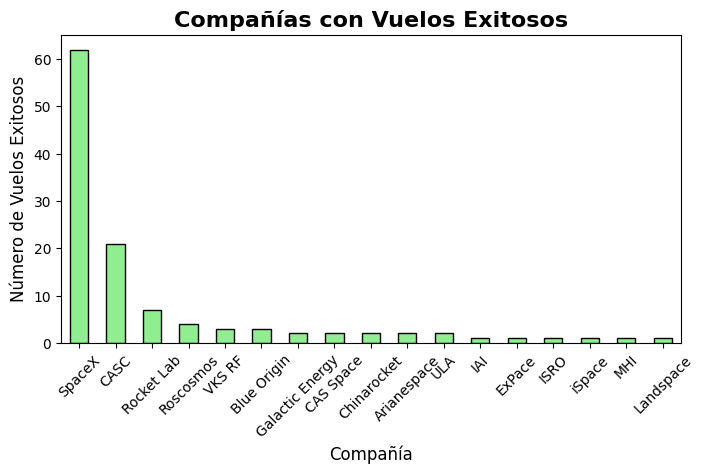


Vuelos exitosos por compañia:
company
SpaceX             62
CASC               21
Rocket Lab          7
Roscosmos           4
VKS RF              3
Blue Origin         3
Galactic Energy     2
CAS Space           2
Chinarocket         2
Arianespace         2
ULA                 2
IAI                 1
ExPace              1
ISRO                1
iSpace              1
MHI                 1
Landspace           1
Name: count, dtype: int64


In [11]:
#Pregunta 1
#Vuelos exitosos por compañia

df_exitosos = df[df['successful'] == '1']

vuelos_exitosos_por_compania = df_exitosos['company'].value_counts()

plt.figure(figsize=(8, 4))
ax = vuelos_exitosos_por_compania.plot(kind='bar', color='lightgreen', edgecolor='black') #el ax creo que se puede quitar
plt.title('Compañías con Vuelos Exitosos', fontsize=16, fontweight='bold')
plt.xlabel('Compañía', fontsize=12)
plt.ylabel('Número de Vuelos Exitosos', fontsize=12)
plt.xticks(rotation=45)
plt.show()

print("\nVuelos exitosos por compañia:")
print(vuelos_exitosos_por_compania)

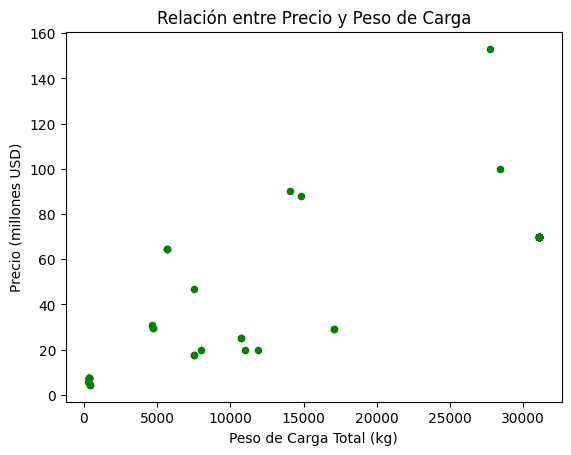

    price_million  total_payload_kg
0           69.75             31100
2           69.75             31100
13          69.75             31100
5           69.75             31100
7           69.75             31100
10          69.75             31100
11          69.75             31100
9           20.00             11000
1           17.42              7500
8            4.38               400


In [12]:
# Relacion entre precio y peso de carga

df_valor_carga = df[['price_million', 'total_payload_kg']]
df_valor_carga = df_valor_carga[df_valor_carga['price_million'] > 0]

df_valor_carga.plot(kind='scatter', x='total_payload_kg', y='price_million', color='green')
plt.title('Relación entre Precio y Peso de Carga')
plt.xlabel('Peso de Carga Total (kg)')
plt.ylabel('Precio (millones USD)')
plt.show()

print(df_valor_carga.head(10).sort_values(by='price_million', ascending=False))

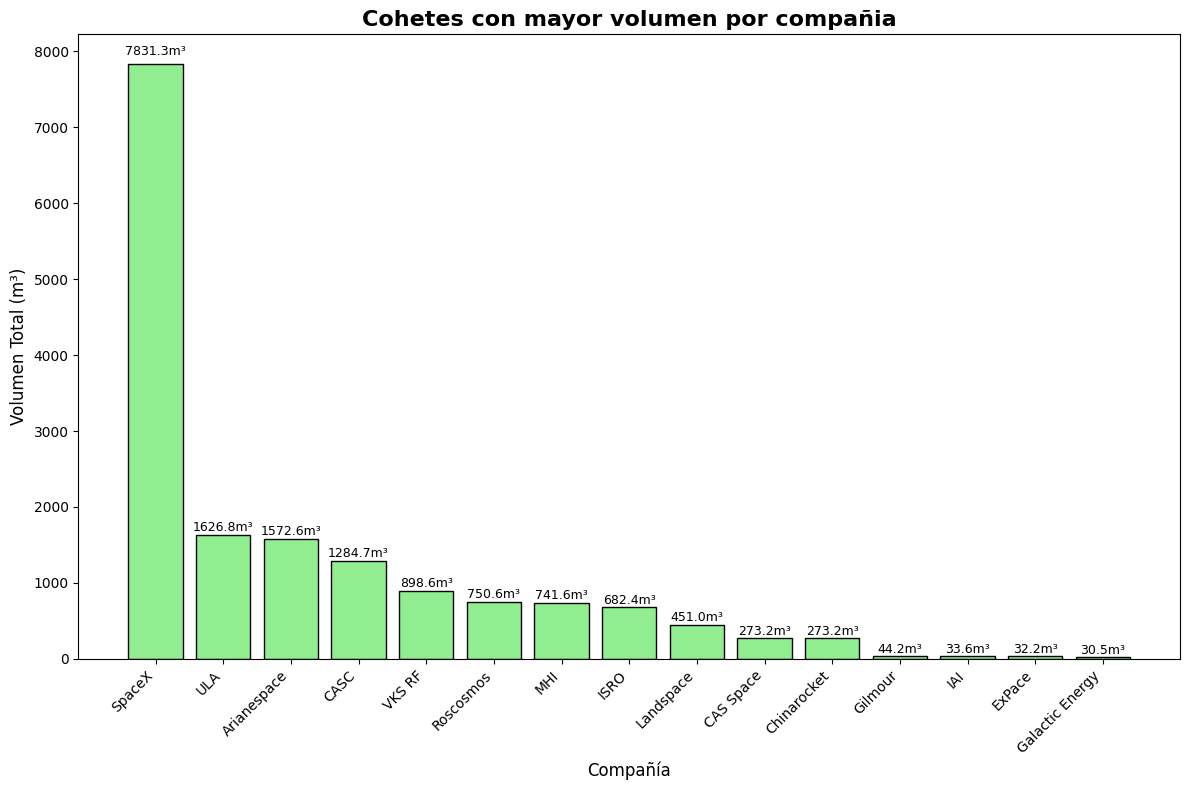

Cohetes con mayor volumen por compañia
            company  volume_total_m3
0            SpaceX      7831.283627
1               ULA      1626.820349
2       Arianespace      1572.618451
3              CASC      1284.706982
4            VKS RF       898.637263
5         Roscosmos       750.604012
6               MHI       741.572396
7              ISRO       682.353924
8         Landspace       450.989697
9         CAS Space       273.238058
10      Chinarocket       273.238058
11          Gilmour        44.178647
12              IAI        33.575595
13           ExPace        32.224363
14  Galactic Energy        30.531045


In [13]:
# Empresas con cohetes más grandes por volumen total

df_big_rockets = df.groupby('company')['volume_total_m3'].max().sort_values(ascending=False)
df_big_rockets = df_big_rockets.rename("volume_total_m3").reset_index()

df_big_rockets_display = df_big_rockets[['company', 'volume_total_m3']].head(15)


plt.figure(figsize=(12, 8))
bars = plt.bar(range(len(df_big_rockets_display)), df_big_rockets_display['volume_total_m3'], color='lightgreen', edgecolor='black')


plt.title('Cohetes con mayor volumen por compañia', fontsize=16, fontweight='bold')
plt.xlabel('Compañía', fontsize=12)
plt.ylabel('Volumen Total (m³)', fontsize=12)


labels = [row['company'] for _, row in df_big_rockets_display.iterrows()]
plt.xticks(range(len(df_big_rockets_display)), labels, rotation=45, ha='right', fontsize=10)


for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01, f'{height:.1f}m³', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


print('Cohetes con mayor volumen por compañia')
print(df_big_rockets_display)

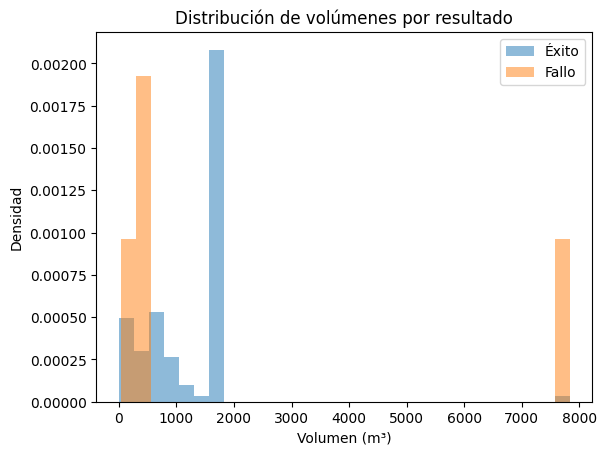

C:\Users\bruno\AppData\Local\Temp\ipykernel_21428\1478986469.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x_success.tolist(), x_fail.tolist()], labels=['Éxito', 'Fallo'], showfliers=True)


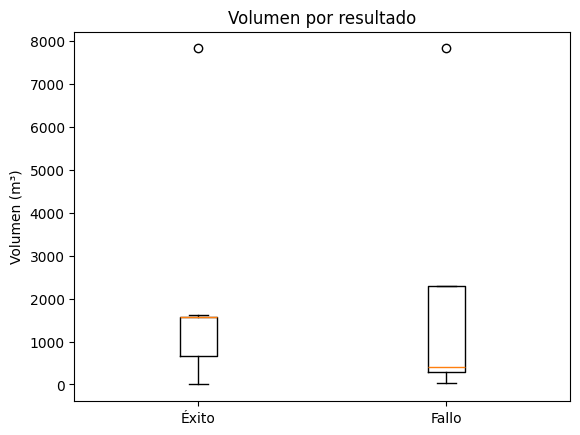

In [14]:
#dudoso, nose si este bueno
df2 = df.copy()

x_success = df2.loc[df2['successful'] == '1', 'volume_total_m3']
x_fail    = df2.loc[df2['successful'] == '0', 'volume_total_m3']

plt.figure()
x_success.plot(kind='hist', bins=30, density=True, alpha=0.5, label='Éxito')
x_fail.plot(kind='hist',    bins=30, density=True, alpha=0.5, label='Fallo')
plt.xlabel('Volumen (m³)'); plt.ylabel('Densidad')
plt.title('Distribución de volúmenes por resultado'); plt.legend()
# plt.xscale('log')  # opcional si hay cola larga
plt.show()

# --- 2) Boxplot lado a lado (matplotlib) ---
plt.figure()
plt.boxplot([x_success.tolist(), x_fail.tolist()], labels=['Éxito', 'Fallo'], showfliers=True)
plt.ylabel('Volumen (m³)')
plt.title('Volumen por resultado')
# plt.yscale('log')  
plt.show()

In [15]:
dfExito = df[df['successful'] == '1']
dfFallo = df[df['successful'] == '0']

porcebtajeExito = float(f"{((len(dfExito) / len(df)) * 100):.2f}")
porcebtajeFallo = float(f"{((len(dfFallo) / len(df)) * 100):.2f}")

print(porcebtajeExito, porcebtajeFallo)

96.67 3.33


Analisis de resultados


In [ ]:
#df country evolution 
df_ce = df[['company', 'successful', 'location', 'year', 'month', 'day']].copy()
df_ce['country'] = df_ce['location'].str.split(', ').str[-1]
df_ce['country'] = df_ce['country'].replace('China Coastal Waters', 'China')




,company,successful,location,year,month,day,country
0,SpaceX,1,"SLC-40, Cape Canaveral SFS, Florida, USA",2025,09,11,USA
1,Roscosmos,1,"Site 31/6, Baikonur Cosmodrome, Kazakhstan",2025,09,11,Kazakhstan
2,SpaceX,1,"SLC-4E, Vandenberg SFB, California, USA",2025,09,10,USA
3,CASC,1,"LC-201, Wenchang Space Launch Site, China",2025,09,8,China
4,Chinarocket,1,"Oriental Spaceport Launch Ship (Area 1), China...",2025,09,8,China
...,...,...,...,...,...,...,...
115,SpaceX,1,"SLC-4E, Vandenberg SFB, California, USA",2025,05,12,USA
116,CASC,1,"LC-3, Xichang Satellite Launch Center, China",2025,05,12,China
117,CASC,1,"LC-9A, Taiyuan Satellite Launch Center, China",2025,05,11,China
118,SpaceX,1,"SLC-40, Cape Canaveral SFS, Florida, USA",2025,05,10,USA


In [ ]:

#df country evolution succeful 
df_ces = df_ce.copy()
df_ces['successful'] = df_ces['successful'].astype(int)

annual_country_stats = (
    df_ces.groupby(['year', 'country']).agg(total_launches=('successful', 'count'),successful_launches=('successful', 'sum')).reset_index())

annual_country_stats['success_rate_pct'] = (annual_country_stats['successful_launches'] / annual_country_stats['total_launches'] * 100).round(2)


annual_country_stats = annual_country_stats.sort_values(['year', 'success_rate_pct'], ascending=[True, False])
annual_country_stats.head(20)


Tasa de éxito anual por país (%):


,year,country,total_launches,successful_launches,success_rate_pct
2,2025,France,2,2,100.00
4,2025,Israel,1,1,100.00
5,2025,Japan,1,1,100.00
6,2025,Kazakhstan,3,3,100.00
7,2025,New Zealand,7,7,100.00
8,2025,Russia,4,4,100.00
9,2025,USA,68,67,98.53
1,2025,China,31,30,96.77
3,2025,India,2,1,50.00
0,2025,Australia,1,0,0.00


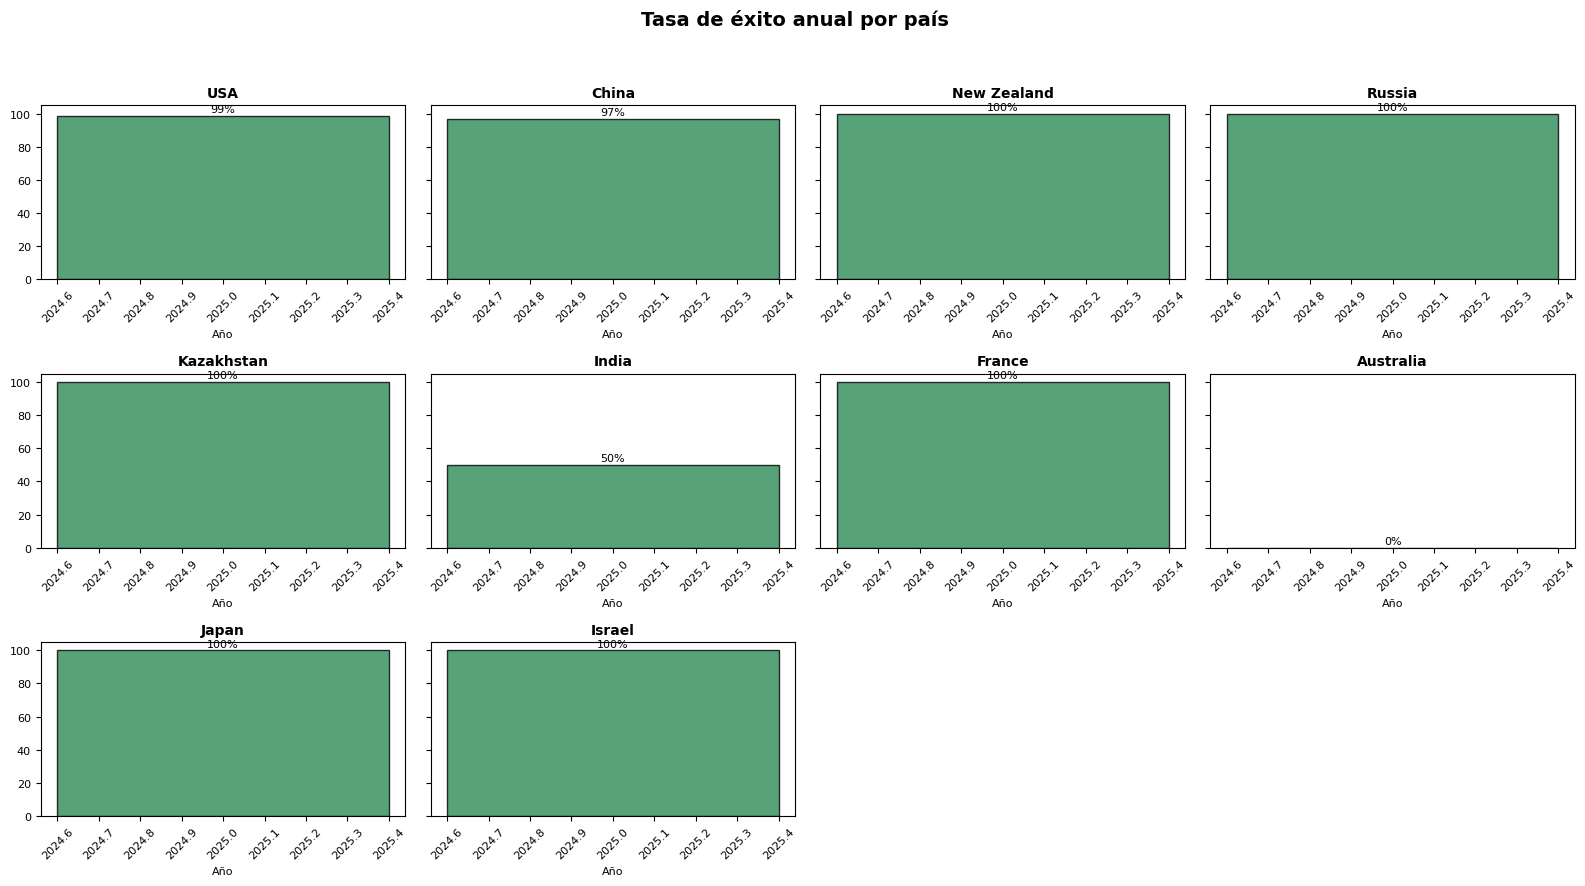

,year,country,total_launches,successful_launches,success_rate_pct
2,2025,France,2,2,100.0
4,2025,Israel,1,1,100.0
5,2025,Japan,1,1,100.0
6,2025,Kazakhstan,3,3,100.0
7,2025,New Zealand,7,7,100.0


In [ ]:
#en desarrollo, si quieres cambiar algo dale noma


import math
import matplotlib.ticker as mtick

acs_rate = annual_country_stats.copy()
acs_rate['year'] = acs_rate['year'].astype(int)

# Ordenar países por total de lanzamientos global
country_order_rate = (acs_rate.groupby('country')['total_launches']
                        .sum()
                        .sort_values(ascending=False)
                        .index.tolist())


acs_rate = acs_rate[acs_rate['country'].isin(country_order_rate)]

n_countries = len(country_order_rate)
cols = 4
rows = math.ceil(n_countries / cols)
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3.0*rows), sharey=True)
axes = axes.flatten()

for i, country in enumerate(country_order_rate):
    ax = axes[i]
    sub = acs_rate[acs_rate['country'] == country].sort_values('year')

    ax.bar(sub['year'], sub['success_rate_pct'], color='seagreen', edgecolor='black', alpha=0.8)

    # Etiquetas sobre cada barra
    for x, y in zip(sub['year'], sub['success_rate_pct']):
        ax.text(x, y + 1, f"{y:.0f}%", ha='center', va='bottom', fontsize=8, color='black')

    ax.set_title(country, fontsize=10, fontweight='bold')
    ax.set_xlabel('Año', fontsize=8)
    ax.tick_params(axis='x', labelrotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_ylim(0, 105)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Tasa de éxito anual por país', fontsize=14, fontweight='bold')
fig.tight_layout(rect=(0,0,1,0.95))
plt.show()

acs_rate.head()